# Conv-PGP

In [1]:
!CUDA_LAUNCH_BLOCKING=1
#!echo PASS | sudo -S nvidia-smi -g 2 -c 0
#fuser -k /dev/nvidia3
#sudo nvidia-smi -i 3 -r
#sudo fuser -v /dev/nvidia*
import datetime,os
folderName=str(datetime.datetime.now().strftime('%Y-%m-%d/%H-%M-%S')).replace(" ","_")+"Orig"
if not os.path.exists('backup/'+folderName+"/"):
    os.makedirs('backup/'+folderName+"/")
codePath="backup/"+folderName+"/code.py"
codeContent=""
def save_code_backup():
    global codeContent
    f= open(codePath,"a+")
    cont=In[-1].replace("save_code_backup()","\r\n#Runned "+str(len(In))+" at "+str(datetime.datetime.now())+"-----\r\n")
    codeContent +=cont
    f.write(cont)
    f.close()
    
print(folderName)

2018-07-25/13-47-33Orig


In [0]:
save_code_backup()
#import torch stuff
import torch
from torchvision import datasets, transforms
from torch.autograd import Variable
from torch.nn import init
import torchviz
from torchviz import make_dot
dtype = torch.FloatTensor

torch.utils.backcompat.broadcast_warning.enabled = True
torch.manual_seed(1)
if torch.cuda.is_available():
    torch.cuda.manual_seed(1)
torch.cuda.empty_cache()

#import rand
import random as rand
rand.seed(1)

#import np
import numpy as np
np.random.seed(1)


#import other
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from IPython.display import clear_output
from IPython.display import Javascript
from shutil import copyfile
import scipy.misc
from scipy.ndimage.interpolation import zoom
from scipy import stats

import os.path
import threading as T
import queue as Q
import time
import math
import tqdm
tqdm.monitor_interval = 0

#import customs
from data_dynamic import bounce_vec

#import visdom
import visdom
viz = visdom.Visdom(port = 9898)
cuda_devices=list()

from tensorboardX import SummaryWriter
writer = SummaryWriter("tensorboard/"+folderName)


channel=1
seq_length=10

if torch.cuda.is_available():
    cuda_devices=[0]
    if(len(cuda_devices)>0):
        torch.cuda.set_device(cuda_devices[0])
        
    
batch_size=-1
poolMethod='avg'#'max','avg', 'none'
MCODE = {
    'A': '.-',     'B': '-...',   'C': '-.-.', 
    'D': '-..',    'E': '.',      'F': '..-.',
    'G': '--.',    'H': '....',   'I': '..',
    'J': '.---',   'K': '-.-',    'L': '.-..',
    'M': '--',     'N': '-.',     'O': '---',
    'P': '.--.',   'Q': '--.-',   'R': '.-.',
    'S': '...',    'T': '-',      'U': '..-',
    'V': '...-',   'W': '.--',    'X': '-..-',
    'Y': '-.--',   'Z': '--..',
    '0': '-----',  '1': '.----',  '2': '..---',
    '3': '...--',  '4': '....-',  '5': '.....',
    '6': '-....',  '7': '--...',  '8': '---..',
    '9': '----.' 
    }

batch_multiplier = max(len(cuda_devices),1)
seqTypeDict = {
              'MMNIST':{'batch_size':42*batch_multiplier,'dimention':2,'classify':True,"regress":False,"class_size":10,'object_count':2,'resolution':64,
                                               'layerParams':[
               {"aeHiddenSize":625,"raepHiddenSize":625,"reapMSize":625,"classificationMSize":625,'orthognality':True,"lr":0.0005,'weight_decay':10e-7,'lr_classification':10e-4,'weight_decay_classification':10e-7},
               {"aeHiddenSize":400,"raepHiddenSize":400,"reapMSize":400,"classificationMSize":400,'orthognality':True,"lr":0.0005,'weight_decay':10e-7,'lr_classification':10e-4,'weight_decay_classification':10e-7},
               {"aeHiddenSize":225,"raepHiddenSize":225,"reapMSize":225,"classificationMSize":225,'orthognality':True,"lr":0.0005,'weight_decay':10e-7,'lr_classification':10e-4,'weight_decay_classification':10e-7},
              ]},
    
              'BBall': {'batch_size':300*batch_multiplier,'dimention':2,'classify':False,"regress":False,'object_count':1,'resolution':64,
                                               'layerParams':[
               {"aeHiddenSize":100,"raepHiddenSize":int(math.pow(10,2)),"reapMSize":int(math.pow(7,2)),'orthognality':True,"lr":0.001,'weight_decay':10e-7,},
               {"aeHiddenSize":100,"raepHiddenSize":int(math.pow(10,2)),"reapMSize":int(math.pow(7,2)),'orthognality':True,"lr":0.001,'weight_decay':10e-7,},
               {"aeHiddenSize":100,"raepHiddenSize":int(math.pow(10,2)),"reapMSize":int(math.pow(7,2)),'orthognality':True,"lr":0.001,'weight_decay':10e-7,},
              ]},
            
              'MMorse':{'batch_size':1500*batch_multiplier,'dimention':1,'classify':True,"regress":True,"class_size":len(MCODE),'object_count':1,'resolution':75,
                                              'layerParams':[
                {"aeHiddenSize":30,"raepHiddenSize":int(math.pow(5,2)),"reapMSize":int(math.pow(6,2)),"classificationMSize":72,"regressorHiddenSize":70,'regressorOutputSize':2,'orthognality':True,"lr":0.0001,'weight_decay':0,'lr_classification':10e-4,'weight_decay_classification':10e-7,'lr_regression':10e-4},
                {"aeHiddenSize":30,"raepHiddenSize":int(math.pow(5,2)),"reapMSize":int(math.pow(6,2)),"classificationMSize":72,"regressorHiddenSize":70,'regressorOutputSize':2,'orthognality':True,"lr":0.0001,'weight_decay':0,'lr_classification':10e-4,'weight_decay_classification':10e-7,'lr_regression':10e-4},
                {"aeHiddenSize":30,"raepHiddenSize":int(math.pow(5,2)),"reapMSize":int(math.pow(6,2)),"classificationMSize":72,"regressorHiddenSize":70,'regressorOutputSize':2,'orthognality':True,"lr":0.0001,'weight_decay':0,'lr_classification':10e-4,'weight_decay_classification':10e-7,'lr_regression':10e-4},
              ]},
                
              'MNoise1D':{'batch_size':3000*batch_multiplier,'dimention':1,'classify':False,"regress":True,'object_count':1,'resolution':75,
                                              'layerParams':[
                {"aeHiddenSize":30,"raepHiddenSize":int(math.pow(10,2)),"reapMSize":int(math.pow(7,2)),"regressorHiddenSize":70,'regressorOutputSize':2,'orthognality':True,"lr":0.001,'weight_decay':10e-7,'lr_regression':10e-3},
                {"aeHiddenSize":30,"raepHiddenSize":int(math.pow(10,2)),"reapMSize":int(math.pow(7,2)),"regressorHiddenSize":70,'regressorOutputSize':2,'orthognality':True,"lr":0.001,'weight_decay':10e-7,'lr_regression':10e-3},
                {"aeHiddenSize":30,"raepHiddenSize":int(math.pow(10,2)),"reapMSize":int(math.pow(7,2)),"regressorHiddenSize":70,'regressorOutputSize':2,'orthognality':True,"lr":0.001,'weight_decay':10e-7,'lr_regression':10e-3},
              ]},
                
              'MNoise2D':{'batch_size':500*batch_multiplier,'dimention':2,'classify':False,"regress":True,'object_count':1,'resolution':24,'action':'shift',
                                              'layerParams':[
                {"aeHiddenSize":50,"raepHiddenSize":int(math.pow(6,2)),"reapMSize":int(math.pow(7,2)),"regressorHiddenSize":70,'regressorOutputSize':2,'orthognality':True,"lr":0.001,'weight_decay':0,'lr_regression':10e-6},
                {"aeHiddenSize":50,"raepHiddenSize":int(math.pow(6,2)),"reapMSize":int(math.pow(7,2)),"regressorHiddenSize":70,'regressorOutputSize':2,'orthognality':True,"lr":0.001,'weight_decay':0,'lr_regression':10e-6},
                {"aeHiddenSize":50,"raepHiddenSize":int(math.pow(6,2)),"reapMSize":int(math.pow(7,2)),"regressorHiddenSize":70,'regressorOutputSize':2,'orthognality':True,"lr":0.001,'weight_decay':0,'lr_regression':10e-6},
              ]}}
    
PAD=10          
seqTypeName = 'BBall' #@param ["MMNIST", "BBall", "MMorse", "MNoise1D", "MNoise2D"]
resolution=seqTypeDict[seqTypeName]['resolution']
modelName="AE_RAEP_MNIST_P"+poolMethod+"_"+seqTypeName
canClassify =  seqTypeDict[seqTypeName]['classify']
object_count= seqTypeDict[seqTypeName]['object_count']
layerParams = seqTypeDict[seqTypeName]['layerParams']
dimention = seqTypeDict[seqTypeName]['dimention']
input_size = int(math.pow(resolution+(PAD*2),dimention) * channel)
batch_size = seqTypeDict[seqTypeName]['batch_size']
shouldClassify = True and canClassify
shouldRegress = seqTypeDict[seqTypeName]['regress']
LocationHint=True

def generateSeq(bs):
    global seqTypeName
    global seqTypeDict
    strF = "get"+seqTypeName+"(batch_size="+str(bs)+")"
    return eval(strF)

def cImg(image):
    o = image.max(axis=2) > 0
    o_columns = np.where(np.any(o, axis=0))[0]
    o_rows = np.where(np.any(o, axis=1))[0]
    return image[min(o_rows):max(o_rows) + 1,
                 min(o_columns):max(o_columns) + 1, :]

BOUNCEINDEX=0
getMMNISTCalled = False
def getMMNIST(batch_size, seq_length=seq_length, shape=resolution,train=True, num_digits=object_count):
    global mmnist_x
    global mmnist_y
    global getMMNISTCalled
    if not getMMNISTCalled:
        mmnist_loader = torch.utils.data.DataLoader(datasets.MNIST('data', train=True, download=True,
                             transform=transforms.Compose([transforms.ToTensor()])),
                             batch_size=3000, shuffle=True)

        for (mmnist_x, mmnist_y) in mmnist_loader:
            break
        getMMNISTCalled = True
    _seq_length = seq_length
    mmnistDS_x = np.empty(shape=(batch_size,seq_length, shape, shape, 1),dtype=np.float32)
    mmnistDS_y = [[[-1] for j in range(num_digits)] for i in range(batch_size)]
    velocity_range= (0, 6)
    digits_batch = mmnist_x.numpy().reshape(mmnist_x.shape[0],mmnist_x.shape[2],mmnist_x.shape[3],mmnist_x.shape[1])
    digits_batch = [cImg(d) for d in digits_batch]

    for seq_idx in range(batch_size):
        sequence = np.empty(shape=(seq_length, shape, shape, 1),
                            dtype=np.float32)
        
        randDigits=[rand.randint(0,len(mmnist_x)-1) for l in
                  range(num_digits)]
        
        digits_y = [mmnist_y[l] for l in randDigits]
        digits_x = [digits_batch[l] for l in randDigits]
        
        positions = np.array([[np.random.randint(0, shape  - d.shape[0]-BOUNCEINDEX),
                               np.random.randint(0, shape  - d.shape[1]-BOUNCEINDEX)] for d in digits_x])
        velocities = np.random.randint(size=(num_digits, 2),
                *velocity_range) * (np.random.randint(0, 2,
                (num_digits, 2)) * 2 - 1)

        for frame_idx in range(seq_length):
            frame = np.zeros((shape, shape, 1))

            positions = positions + velocities

            for d_idx in range(num_digits):
                for dimen in range(2):
                    if positions[d_idx,dimen] < BOUNCEINDEX:
                        positions[d_idx,dimen] = BOUNCEINDEX
                        velocities[d_idx,dimen] *= -1
                    if positions[d_idx,dimen] >= shape - digits_x[d_idx].shape[dimen]-BOUNCEINDEX:
                        positions[d_idx,dimen] = shape - digits_x[d_idx].shape[dimen]-BOUNCEINDEX
                        velocities[d_idx,dimen] *= -1

                digit_mat = np.zeros((shape, shape, 1))

                digit_mat[positions[d_idx][0]:
                          positions[d_idx][0]
                          + digits_x[d_idx].shape[0],
                          positions[d_idx][1]:
                          positions[d_idx][1]
                          + digits_x[d_idx].shape[1]] = \
                    digits_x[d_idx]

                frame = np.clip(np.add(digit_mat, frame), 0.,
                        1.)

            np.copyto(sequence[frame_idx], frame)
            del frame

        np.copyto(mmnistDS_x[seq_idx], sequence)
        mmnistDS_y[seq_idx] = digits_y
        del sequence
        
    mmnistDS_y = np.array(mmnistDS_y,np.int32)
    mmnistDS_y.sort(axis=1)
    if batch_size==1:
        return mmnistDS_x[0,:],mmnistDS_y[0,:]
    return mmnistDS_x,mmnistDS_y

def getBBall(batch_size, seq_length=seq_length, shape=resolution,train=True, num_balls=object_count,ballSize=1):
    dat = np.zeros((batch_size, seq_length, shape, shape, 1))
    res, nballs, radius = shape, num_balls, ballSize

    def balls(): return bounce_vec(res, n=nballs, r=[radius] * nballs, T=seq_length)
    a = np.reshape(balls(), (seq_length, shape, shape, 1))

    for i in range(batch_size):
        dat[i, :, :, :, :] = np.reshape(bounce_vec(res, n=nballs, r=[radius] * nballs, T=seq_length), (seq_length, shape, shape, 1))  
    
    if batch_size==1:
        return dat[0,:]  
    return dat

def seqRecToSeq(flat,twoDRatio=1):#ratio 0 menas 1D
    flat=flat.permute(1,0,2).contiguous()#change the order
    sqRes=math.sqrt((flat.shape[2]/channel)/twoDRatio)
    if twoDRatio>0 and sqRes == round(sqRes):
        sqRes=int(sqRes)
        return flat.view(flat.shape[0],flat.shape[1],sqRes,sqRes*twoDRatio,channel).data.cpu().numpy()
    else:
        dim=int(flat.shape[2]/channel)
        return flat.view(flat.shape[0],flat.shape[1],dim,1,channel).data.cpu().numpy()
        
def getMNoise2D(batch_size, seq_length=seq_length,train=True):
    shape = resolution
    dat = np.zeros((batch_size, seq_length, shape, shape, 1))
    regC=[]
    if seqTypeDict[seqTypeName]['action']=='rotation':
        for j in range(batch_size):
            mcImg = np.random.randn(shape,shape)
            height = seq_length
            res = np.zeros((height,shape,shape))
              
            randRot= np.random.random(1)[0]#np.random.vonmises(0.0, 1.0)
            regC.append([randRot])
            angle_delta = (((randRot*2)-1)) * 45#(((randRot*2)-1)/np.pi) * 45  
            
            for i in range(height):
                res[i,:] =scipy.ndimage.rotate(mcImg,i*angle_delta,reshape=False,mode='nearest',order=3)
            
            dat[j, :, :, :, :] = res.reshape(seq_length,shape,shape,1)
    elif  seqTypeDict[seqTypeName]['action']=='shift':
        for j in range(batch_size):
            mcImg = np.random.randn(shape,shape)
            height = seq_length
            res = np.zeros((height,shape,shape))
              
            randShift= np.random.random(2)
            regC.append(randShift)
            shift_delta = randShift * 6 - 3
            
            for i in range(height):
                res[i,:] =scipy.ndimage.shift(mcImg,i*shift_delta,mode='wrap',order=3)
            
            dat[j, :, :, :, :] = res.reshape(seq_length,shape,shape,1)

    regC = np.array(regC,np.float32)
    if batch_size==1:
        return dat[0,:],regC[0,:]
    return dat,regC

def getMNoise1D(batch_size, seq_length=seq_length,train=True,sin=True):
    shape = resolution
    dat = np.zeros((batch_size, seq_length, shape, 1, 1))
    regC=[]
    if sin:
        for j in range(batch_size):
            mcImg = np.random.rand(50)
            height = seq_length
            res = np.zeros((height,shape))
            
            freeSpace=shape//2-len(mcImg)//2
            randMotion= np.random.random(3)
            regC.append(randMotion[0:2])
            amp = randMotion[0]*(freeSpace-1)
            freq = 0.0+randMotion[1]*0.1#*0.2
            phase = 1*math.pi
            middleArr=np.zeros(shape)
            middleArr[freeSpace:freeSpace+len(mcImg)]=mcImg
            for i in range(height):
                res[i,:] =scipy.ndimage.interpolation.shift(middleArr,amp*math.sin(i*freq+phase),order=1)
            
            dat[j, :, :, :, :] = res.reshape(seq_length,shape,1,1)
            

    regC = np.array(regC,np.float32)
    if batch_size==1:
        return dat[0,:],regC[0,:]
    return dat,regC
        
getMMorseCalled = False
def getMMorse(batch_size, seq_length=seq_length,train=True,sin=True):
    global mcImg
    global getMMorseCalled
    global MCODE
    global dWidth
    if not getMMorseCalled:
        dWidth = {'.':[0.2,0.8,1,1,1,0.8,0.2],'-':[0.2,0.6,0.8,1,1,1,1,1,0.8,0.6,0.2],' ':1}
        getMMorseCalled = True
    shape = resolution
    dat = np.zeros((batch_size, seq_length, shape, 1, 1))
    datC = []
    keys=list(MCODE.keys())
    values=list(MCODE.values())
    regC=[]
    if sin:
        for j in range(batch_size):
            smc = rand.choice(values)
            datC.append([values.index(smc)])
            mcImg = np.zeros(0)
            mcIdx = 0
            for idx,c in enumerate(smc):
                mcImg = np.append(np.append(mcImg,dWidth[c]),[0]*(dWidth[' '] if idx<len(smc)-1 else 0))
            height = seq_length
            res = np.zeros((height,shape))

            freeSpace=shape//2-len(mcImg)//2
            randMotion= np.random.random(3)
            regC.append(randMotion[0:2])
            amp = randMotion[0]*(freeSpace-1)
            freq = 0.0+randMotion[1]*0.1
            phase = 0*math.pi
            middleArr=np.zeros(shape)
            middleArr[freeSpace:freeSpace+len(mcImg)]=mcImg
            for i in range(height):
                res[i,:] =scipy.ndimage.interpolation.shift(middleArr,amp*math.sin(i*freq+phase),order=1)
            
            dat[j, :, :, :, :] = res.reshape(seq_length,shape,1,1)
    else:
        for j in range(batch_size):
            smc = rand.choice(values)
            datC.append([values.index(smc)])
            mcImg = np.zeros(0)
            mcIdx = 0
            for idx,c in enumerate(smc):
                mcImg = np.append(np.append(mcImg,dWidth[c]),[0]*(dWidth[' '] if idx<len(smc)-1 else 0))
            height = seq_length
            pSpeed = rand.randint(-3,3)
            res = np.zeros((height,shape))
            idxS = rand.randint(0,res.shape[1]-len(mcImg))
            shift=0
            preidxS = [idxS]
            for i in range(height):
                if int(idxS+pSpeed) < 0 or int(idxS+pSpeed)+len(mcImg)>=res.shape[1]:
                    pSpeed*=-1

                idxS +=pSpeed
                res[i,int(idxS):int(idxS)+len(mcImg)] = mcImg

            dat[j, :, :, :, :] = res.reshape(seq_length,shape,1,1)
    
    datC = np.array(datC,np.int32)
    regC = np.array(regC,np.float32)
    if batch_size==1:
        return dat[0,:],datC[0,:],regC[0,:]
    return dat,datC,regC

#([samples, seq, shape, shape, colorchannel])
def showSeq(step,caption,data,relDataArray=[],revert=False,oneD=False,dpi=1):
    global writer
    if data.shape[3]==1 and not oneD:
        dimsqrt=int(math.sqrt(data.shape[2]))
        if(dimsqrt*dimsqrt == data.shape[2]):
            data=data.reshape((data.shape[0],data.shape[1],dimsqrt,dimsqrt,data.shape[4]))
        else:
            print("Error while reshaping")
            return
            
    
    mData=data
    if(len(relDataArray)>0):
        space = np.ones((data[0].shape[0],max(1,data[0].shape[1]//20),data[0].shape[2],data[0].shape[3]))
        for i in range(len(relDataArray)):
            if relDataArray[i].shape[3]==1 and  not oneD:
                dimsqrt=int(math.sqrt(relDataArray[i].shape[2]))
                if(dimsqrt*dimsqrt == relDataArray[i].shape[2]):
                    relDataArray[i]=relDataArray[i].reshape((relDataArray[i].shape[0],relDataArray[i].shape[1],dimsqrt,dimsqrt,relDataArray[i].shape[4]))
                else:
                    print("Error while reshaping")
                    return
            if relDataArray[i].shape == data.shape:
                mData = np.array([np.hstack([mData[j],space,relDataArray[i][j]]) for j in range(len(data))])
    data = mData
    print(caption + ("(r)" if revert else "")+"  "+str(data.shape))
    cmap='gray'#'jet'
    cmap+='_r' if revert else ''
    imgs_combArrey=[]
    for b in range(data.shape[0]):
        if oneD:
            imgs_combArrey.append(np.vstack([data[b,i,:,:,0].reshape(data.shape[2]*data.shape[3]) for i in range(data.shape[1])]))
        else:
            imgs_combArrey.append(np.hstack([data[b,i//2,:,:,0] if i%2==0 else np.ones((data.shape[2],1)) for i in range(data.shape[1]*2-1)]))
        if(b<data.shape[0]-1):
            imgs_combArrey.append(np.ones((1,imgs_combArrey[-1].shape[1])))
    
    finalImg = np.vstack(imgs_combArrey)
    dpi=240*dpi
    if not oneD:
        figsize=(5*data.shape[1], (len(relDataArray)+1)*len(imgs_combArrey))
    else:
        figsize=(10*(len(relDataArray)+1)*len(imgs_combArrey),5*data.shape[1])

    tImg=torch.from_numpy(finalImg)
    writer.add_histogram(tag=caption+"/H",values=finalImg.flatten(),bins='doane',global_step=step)
    writer.add_image(caption+"/I",tImg.unsqueeze(0), step)
    plt.figure(figsize=figsize,dpi=dpi)
    plt.imshow(finalImg,cmap=cmap)
    plt.axis('off')
    plt.show()
    matplotlib.image.imsave("tensorboard/"+folderName+"/"+caption+str(step)+'.png', finalImg)
    
current_file = '.ipynb_checkpoints/AE+RAEP_Complete-checkpoint.ipynb'
def notebook_save():
    global current_file
    script = '''
require(["base/js/namespace"],function(Jupyter) {
    Jupyter.notebook.save_checkpoint();
});
'''
    os.remove(current_file)
    while not os.path.exists(current_file):
        Javascript(script)
        time.sleep(0.1)
    
def output_HTML(read_file, output_file):
    from nbconvert import HTMLExporter
    import codecs
    import nbformat
    exporter = HTMLExporter()
    # read_file is '.ipynb', output_file is '.html'
    output_notebook = nbformat.read(read_file, as_version=4)
    output, resources = exporter.from_notebook_node(output_notebook)
    codecs.open(output_file, 'w', encoding='utf-8').write(output)
    
def save_html():
    global current_file
    if not os.path.exists('backup/'+folderName+"/"):
        os.makedirs('backup/'+folderName+"/")
    copyfile(current_file,'backup/'+folderName+"/"+"backup.ipynb")
    output_file = 'backup/'+folderName+"/"+str(datetime.datetime.now())+'.html' 
    output_HTML(current_file, output_file)

class DataSet(torch.utils.data.Dataset):
    def __init__(self,max_data):
        self.max_data=max_data
        pass
    def __getitem__(self, index):
        return generateSeq(bs=1)
    def __len__(self):
        return self.max_data*200

dsObj=DataSet(batch_size)
train_loader = torch.utils.data.DataLoader(
               dataset=dsObj,
               batch_size=batch_size, shuffle=False,num_workers=20,worker_init_fn=(lambda id: np.random.seed()))#'''np.random.get_state()[1][0]+id'''


def gaussian_noise(ins, is_training):
    return ins
    if is_training:
        noise = Variable(ins.data.new(ins.size()).normal_(mean=0, std=0.05))
        return ins + noise
    return ins

def flip(x, dim):
    dim = x.dim() + dim if dim < 0 else dim
    inds = tuple(slice(None, None) if i != dim
             else x.new(torch.arange(x.size(i)-1, -1, -1).tolist()).long()
             for i in range(x.dim()))
    return x[inds]

In [0]:
def occludedDS(ds,val=0):
    stride=3.
    space=3
    maxRange=int(ds.shape[2]/stride)
    res=ds.clone()
    for i in range(1,maxRange):
        maxStep=int(i*stride+stride)
        minStep=int(i*stride)
        if i%space==0 and maxStep<ds.shape[2]:
            res[:,:,:,minStep:maxStep,:]=res[:,:,minStep:maxStep,:,:]=val
    return res

def padDS(ds):
    return torch.nn.functional.pad(ds,(0,0,PAD,PAD,PAD,PAD))

(300, 10, 64, 64, 1)
testGenerateSeq  torch.Size([5, 10, 84, 84, 1])


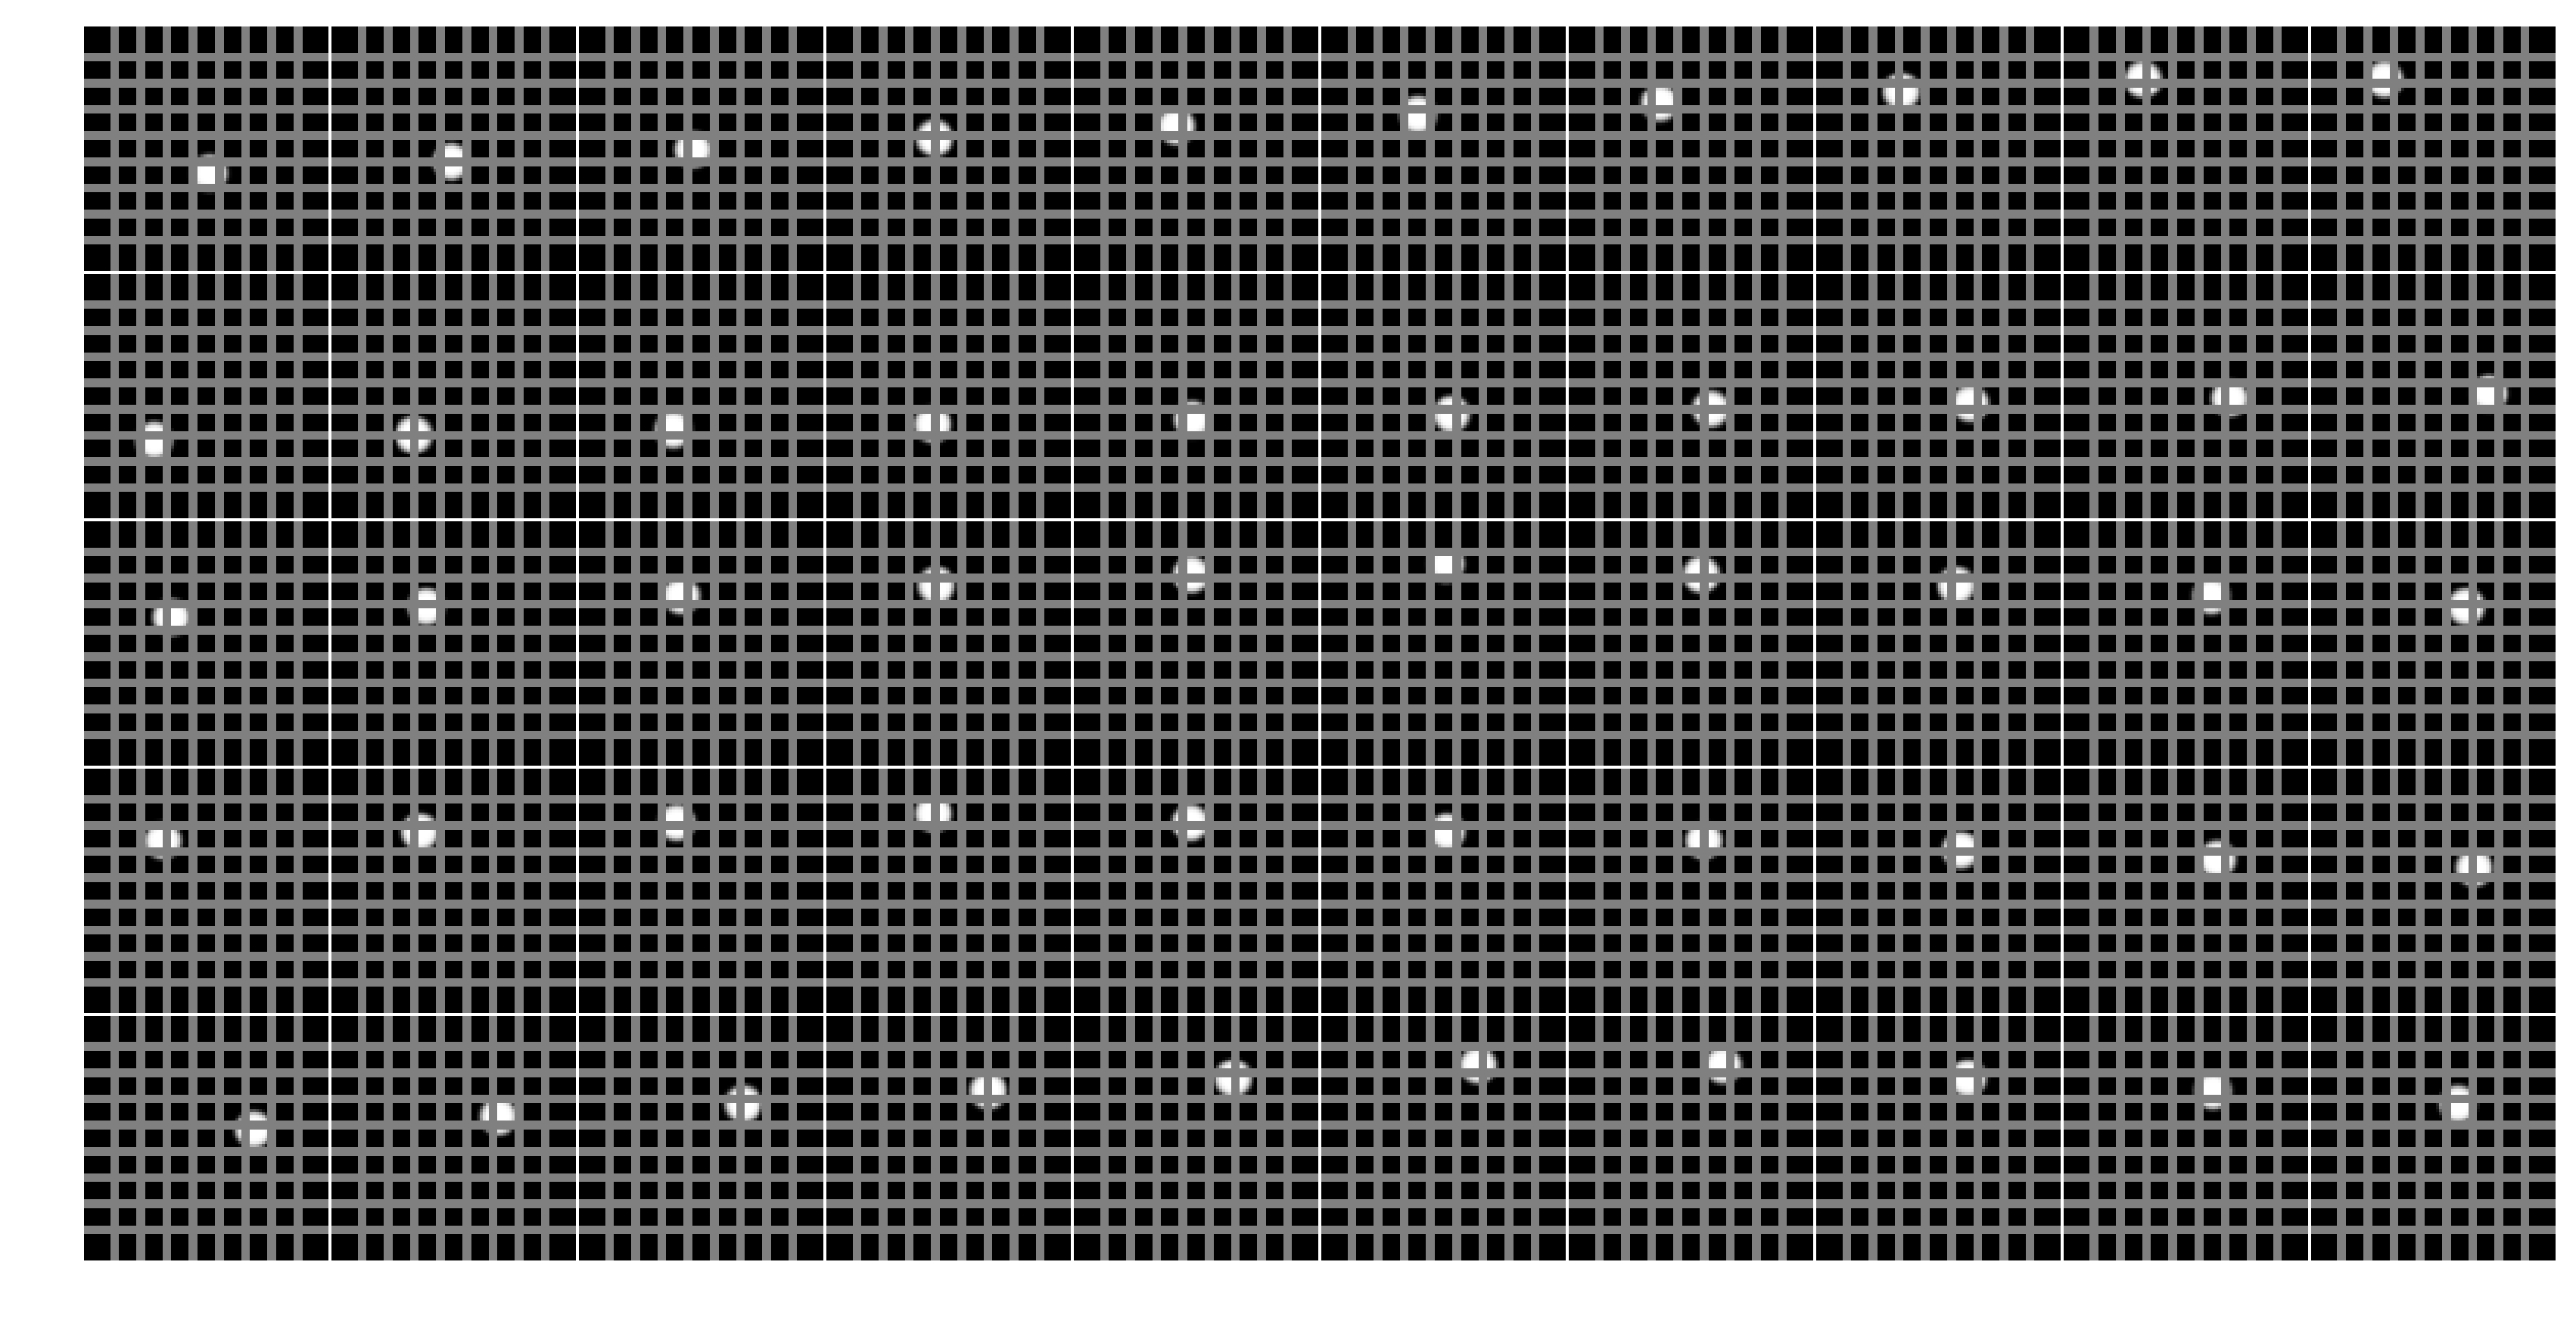

CPU times: user 4.3 s, sys: 324 ms, total: 4.62 s
Wall time: 4.21 s


In [4]:
%%time
showIt = True #@param {type:"boolean"}
if(showIt):
    dataSet = generateSeq(batch_size)
    if type(dataSet) is tuple:
        if(len(dataSet)==2):
            dataSet,ds_target = dataSet
        elif (len(dataSet)==3):
            dataSet,ds_target,regY = dataSet
        print(ds_target.shape)

    print(dataSet.shape)
    dataSet=occludedDS(padDS(torch.from_numpy(dataSet)),0.5)
    showSeq(0,"testGenerateSeq",dataSet[0:5,:,:,:],revert=False,oneD=(dimention==1),dpi=0.5*dimention)

In [0]:
AI=False

In [0]:
class Conv_RAE(torch.nn.Module):
    def __init__(self,batchSize, in_channels, out_channels, m_channels, kernel_size):
        super().__init__()
        self.conv2d_layer_u1 = torch.nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=1, padding=(kernel_size-2)//2+1, bias= True) # u1 #default bias = True
        self.conv2d_layer_u2 = torch.nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=1, padding=(kernel_size-2)//2+1, bias= True) # u2
        
        self.conv2d_layer_w = torch.nn.Conv2d(in_channels=out_channels, out_channels=m_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias = True)# w1

        self.conv2d_layer_w2 = torch.nn.Conv2d(in_channels=m_channels, out_channels=out_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias= True)# w2
        self.deconv2d_layer_u2T = torch.nn.ConvTranspose2d(in_channels=out_channels, out_channels=1, kernel_size=kernel_size, stride=1, padding=(kernel_size-1)//2, output_padding=0, bias =True)

#         self.deconv2d_layer_u2T.weight = self.conv2d_layer_u2.weight

        for _i in self.modules():
            if isinstance(_i, torch.nn.Conv2d):
                torch.nn.init.orthogonal_(_i.weight.data)
        self.m = None
        self.m_prim = None

        self.nonlin = torch.nn.Sigmoid()
        self.nonlinRelu = torch.nn.ReLU()
        self.locationEncode=torch.zeros(1,3,64+(PAD*2),64+(PAD*2))#:,:,:,minStep:maxStep,:
        for i in range(64+(PAD*2)):
            self.locationEncode[0,1,:,i]=self.locationEncode[0,0,i,:]=i/float(64+(PAD*2)-1)
        
        stride=3.
        space=3
        maxRange=int(64+(PAD*2)/stride)
        for i in range(1,maxRange):
            maxStep=int(i*stride+stride)
            minStep=int(i*stride)
            if i%space==0 and maxStep<64+(PAD*2):
                self.locationEncode[0,2,:,minStep:maxStep]=self.locationEncode[0,2,minStep:maxStep,:]=1

    def forward(self, x, y):
        if x is None:
            print("Programming Error")
        if self.locationEncode.device != x.device:
            self.locationEncode=self.locationEncode.to(x.get_device())
            
        if not AI:
            xtmp=torch.cat((x,x,x,x),dim=1)
        else:
            xtmp=torch.cat((x,self.locationEncode.repeat(x.shape[0],1,1,1)),dim=1)
        
        self.cor_x1 = gaussian_noise(xtmp, is_training=y is not None)
        self.f_cor_x = self.conv2d_layer_u1(self.cor_x1)

        if(self.m is not None):
            self.m_prim = self.m.clone()
        if(y is not None):
            
            if not AI:
                ytmp=torch.cat((y,y,y,y),dim=1)
            else:
                ytmp=torch.cat((y,self.locationEncode.repeat(y.shape[0],1,1,1)),dim=1)
            self.cor_y1 = gaussian_noise(ytmp, is_training=True)
            self.f_cor_y = self.conv2d_layer_u2(self.cor_y1)
            mult_x_y = self.f_cor_x * self.f_cor_y 
            self.m = self.conv2d_layer_w(mult_x_y)
            self.m = self.nonlinRelu(self.m)


        reconstructed_factor = self.conv2d_layer_w2(self.m)
        rec_e3 = reconstructed_factor * self.f_cor_x
        self.rec = self.deconv2d_layer_u2T(rec_e3)
        self.rec = self.nonlin(self.rec)
        return self.rec[:,:,:,:]#([250, 3, 64, 64])
    
class Conv_PGP(torch.nn.Module):
    def __init__(self,  batchSize, in_channels, out_channels, m_channels, kernel_sizes):
        super().__init__()
        self.nb_layers=len(in_channels)
        self.rae_layers = torch.nn.ModuleList([Conv_RAE(batchSize, in_channels[i], out_channels[i], m_channels[i], kernel_sizes[i]) for i in range(self.nb_layers)])

    def forward(self, inputs):
        first_layer_frames = []
        m_frames = []
        m_1_frames = []
        inputs=inputs.permute(1,0,4,3,2)
        first_layer_frames.append(inputs[0])
        for i in range(len(inputs)):
            max_avalible_layer = min(i, self.nb_layers)
            if i < 3:  # reconstruct
                for j in range(max_avalible_layer):
                    if j == 0:
                        first_layer_frames.append(self.rae_layers[j](inputs[i - 1], inputs[i]))
                        if self.rae_layers[j].m is not None:
                        	m_frames.append(self.rae_layers[j].m.clone().data[ :,0,:,:].contiguous().cpu().numpy())
                    else:
                        self.rae_layers[j](self.rae_layers[j - 1].m_prim, self.rae_layers[j - 1].m)  # fill m in self.rae_layers[j]
                        if self.rae_layers[j].m is not None and (j == 1):
                        	m_1_frames.append(self.rae_layers[j].m.clone().data[ :,0,:,:].contiguous().cpu().numpy())

            else:  # predict
                for j in range(max_avalible_layer - 1, -1, -1):
                    if j == 0:
                        
                        first_layer_frames.append(self.rae_layers[j](first_layer_frames[-1], None))
                        m_frames.append(self.rae_layers[j].m.clone().data[ :,0,:,:].contiguous().cpu().numpy())
                    else:
                        self.rae_layers[j - 1].m = self.rae_layers[j](self.rae_layers[j - 1].m, None)
                        if j == 1:
	                        m_1_frames.append(self.rae_layers[j].m.clone().data[ :,0,:,:].contiguous().cpu().numpy())



        first_layer_frames = torch.stack(first_layer_frames).permute(1,0,4,3,2)

        return first_layer_frames

In [0]:
save_code_backup()
lossLog = []
model=None
loss=None
optimizer=None
shouldLoadModel = False #@param {type:"boolean"}
added=""
def modelAccess(model):
    if(len(cuda_devices)>0):
        return model.module
    return model

loadIt = None

if os.path.exists(modelName+added+".th") and shouldLoadModel:
    loadIt = torch.load(modelName+".th")
    lossLog = loadIt["lossLog"]


model=Conv_PGP(batch_size,in_channels=[4],out_channels=[36],m_channels=[20],kernel_sizes=[11])   
if loadIt:
        model.load_state_dict(loadIt["model"][i])

optimizer=torch.optim.Adam(model.parameters(), lr=0.0004,weight_decay=0.00001,amsgrad=True)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.8, last_epoch=-1)
loss = torch.nn.BCELoss()

if len(cuda_devices)>0:
    with torch.cuda.device(cuda_devices[0]):
        model = torch.nn.DataParallel(model, device_ids=cuda_devices,dim=1).cuda()
        loss = loss.cuda()

                
def save_model(added=""):
    global lossLog
    global model
    
    saveIt = {
      'model': [],
      'lossLog': lossLog,
    }
    
    saveIt["model"].append(modelAccess(model).state_dict())#cpu() removed
    torch.save(saveIt, modelName+added+".th")
    print("Model saved ",modelName+added+".th")
    
t=0        

In [0]:
t=0

 54%|█████▎    | 53650/100000 [22:42:13<19:36:01,  1.52s/it]


53650  Loss= 264.8558224439621
Number of Parameters =  40773
LMIN =  58.462561056017876


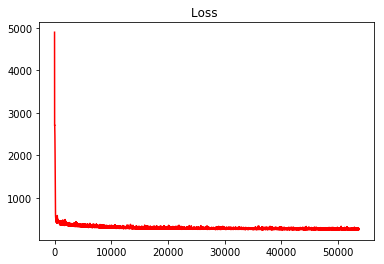

GT,IN,DS,Pred  (1, 10, 348, 84, 1)


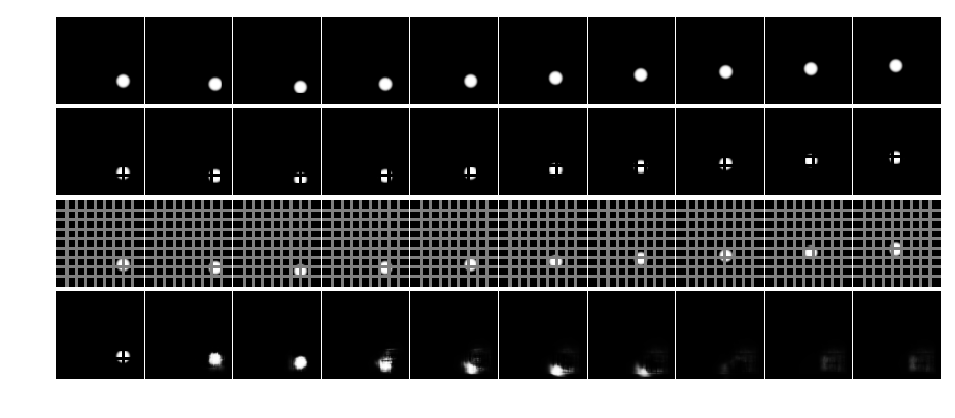

53651  Loss= 266.9104138612747
53652  Loss= 269.840895652771
53653  Loss= 264.4514703154564
53654  Loss= 264.1724218726158
53655  Loss= 257.23096042871475
53656  Loss= 265.93256145715714
53657  Loss= 255.1985540986061
53658  Loss= 258.71849155426025
53659  Loss= 265.7947720885277
53660  Loss= 266.4363784790039
53661  Loss= 268.29871666431427
53662  Loss= 257.6753718852997
53663  Loss= 256.4034093618393
53664  Loss= 253.86077231168747
53665  Loss= 257.275961458683
53666  Loss= 255.7796772122383
53667  Loss= 259.55350774526596
53668  Loss= 257.1077070236206
53669  Loss= 264.0757432579994
53670  Loss= 269.5154267549515
53671  Loss= 258.69628018140793
53672  Loss= 267.6706999540329
53673  Loss= 257.8203372359276
53674  Loss= 257.0302957892418
53675  Loss= 255.97524243593216
53676  Loss= 258.6700208187103
53677  Loss= 263.8868283033371
53678  Loss= 264.4335697889328
53679  Loss= 267.81866186857224
53680  Loss= 259.13724821805954
53681  Loss= 268.9827743768692
53682  Loss= 269.92387944459915

Process Process-5378:
Process Process-5380:
Process Process-5374:
Process Process-5379:
Process Process-5370:
Process Process-5373:
Process Process-5372:
Process Process-5361:
Process Process-5367:
Process Process-5377:
Process Process-5363:
Process Process-5375:
Process Process-5365:
Process Process-5368:
Process Process-5369:
Process Process-5371:
Process Process-5364:
Process Process-5376:
Traceback (most recent call last):
Traceback (most recent call last):
Process Process-5362:
Process Process-5366:
  File "/home/VI/staff/hfarazi/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/VI/staff/hfarazi/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/VI/staff/hfarazi/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/VI/staff/hfara

  File "/home/VI/staff/hfarazi/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/VI/staff/hfarazi/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/VI/staff/hfarazi/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/VI/staff/hfarazi/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "<ipython-input-2-e528b3cd26eb>", line 140, in generateSeq
    return eval(strF)
  File "/home/VI/staff/hfarazi/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/home/VI/staff/hfarazi/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/VI/staff/hfarazi/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self

  File "/home/VI/staff/hfarazi/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
    r = index_queue.get()
  File "/home/VI/staff/hfarazi/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
    r = index_queue.get()
  File "/home/VI/staff/hfarazi/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
    r = index_queue.get()
  File "/home/VI/staff/hfarazi/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
    r = index_queue.get()
  File "<ipython-input-2-e528b3cd26eb>", line 231, in getBBall
    a = np.reshape(balls(), (seq_length, shape, shape, 1))
  File "/home/VI/staff/hfarazi/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/VI/staff/hfarazi/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*se

  File "/home/VI/staff/hfarazi/anaconda3/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/home/VI/staff/hfarazi/anaconda3/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/home/VI/staff/hfarazi/anaconda3/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/home/VI/staff/hfarazi/anaconda3/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/home/VI/staff/hfarazi/anaconda3/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/home/VI/staff/hfarazi/DFG/data_dynamic.py", line 106, in bounce_vec
    V = matricize(x,res,r)
  File "/home/VI/staff/hfarazi/anaconda3/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/home/VI/staff/hfarazi/anaconda3/

  File "/home/VI/staff/hfarazi/anaconda3/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/home/VI/staff/hfarazi/anaconda3/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt
  File "/home/VI/staff/hfarazi/anaconda3/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/home/VI/staff/hfarazi/anaconda3/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
  File "/home/VI/staff/hfarazi/anaconda3/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
  File "/home/VI/staff/hfarazi/anaconda3/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/home/VI/staff/hfarazi/anaconda3/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
KeyboardInte

KeyboardInterrupt: ignored

In [9]:
# import cProfile
# cp = cProfile.Profile()
# cp.enable()
save_code_backup()
writer.add_text(tag="code",text_string='`'+codeContent.replace("\n","\n\n").replace("\r","").replace("#","'#'").replace("    ","&nbsp;&nbsp;&nbsp;&nbsp;")+'`')
paintEvery=50
saveEvery=1000


train=True

runs=100000
pbar = tqdm.tqdm(total = runs)
while t <= runs:
    
    for dataSet in train_loader:
        if t%paintEvery==0:
            if train:
                clear_output()
            pbar.update(paintEvery if t>0 else 0)
            print("")
        if  t>0 and t%saveEvery==0:
            save_model(str(t//saveEvery))
        dataSetCTarget = None
        if type(dataSet) is list and len(dataSet)==2:
            if shouldRegress:
                dataSet,regY = dataSet[0],dataSet[1]
            elif shouldClassify:
                dataSet,dataSetCTarget = dataSet[0],dataSet[1]
            else:
                raise BaseException("Programming Error!")
        elif type(dataSet) is list and len(dataSet)==3:
            dataSet,dataSetCTarget,regY = dataSet[0],dataSet[1],dataSet[2]
        dataSet=padDS(dataSet)
        temp_ds = dataSet.float().permute(0,1,2,3,4).contiguous()
        batch_ds = Variable(temp_ds, requires_grad=False)


        if(len(cuda_devices)>0):
            with torch.cuda.device(cuda_devices[0]):
                    batch_ds=batch_ds.cuda()

        pre_frames_batch=model(occludedDS(batch_ds[:,0:seq_length,:,:,:]))
        optimizer.zero_grad()

        l=loss(pre_frames_batch[:,1:,:,:,:],batch_ds[:,1:seq_length,:,:,:])
        lMin=loss(batch_ds[:,1:seq_length,:,:,:],batch_ds[:,1:seq_length,:,:,:])
        
        l.backward()
        print(t," Loss=",l.item()*7056)
        lossLog.append(l.item()*7056)
#         scheduler.step(l.item())
        writer.add_scalar("BCE Loss",l.item()*7056,t)
        optimizer.step()
        

        if t%paintEvery==0:
            print("Number of Parameters = ",sum(p.numel() for p in model.parameters() if p.requires_grad))
            print("LMIN = ",lMin.item()*7056)
            x = range(len(lossLog))
            plt.plot(x, lossLog,'r')
            plt.title('Loss ')
            plt.show()
            showSeq(t,"GT,IN,DS,Pred",batch_ds[0:1,:,:,:,:].data,[(occludedDS(batch_ds[0:1,:,:,:,:]).data),(occludedDS(batch_ds[0:1,:,:,:,:],0.5).data),(pre_frames_batch.data[0:1,:,:,:,:])],oneD=(dimention==1),dpi=0.5)
     
            
        t=t+1
        
        if(not train and t>runs):
            raise BaseException("end here")
pbar.close()

# cp.disable()
# cp.priint_stats()

module.rae_layers.0.conv2d_layer_u1.weight  torch.Size([36, 4, 11, 11, 1])


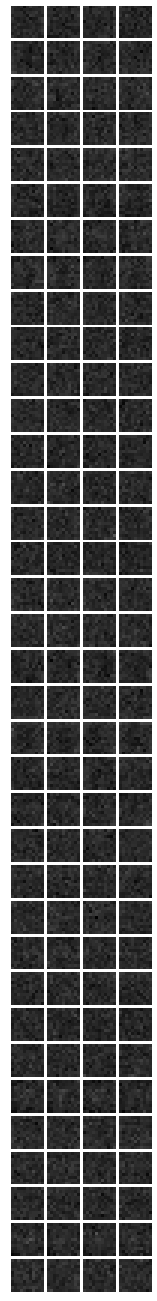

***** module.rae_layers.0.conv2d_layer_u1.bias ##> torch.Size([36])
module.rae_layers.0.conv2d_layer_u2.weight  torch.Size([36, 4, 11, 11, 1])


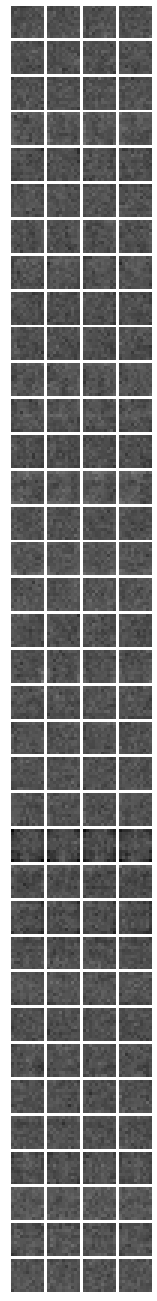

***** module.rae_layers.0.conv2d_layer_u2.bias ##> torch.Size([36])
module.rae_layers.0.conv2d_layer_w.weight  torch.Size([20, 36, 1, 1, 1])


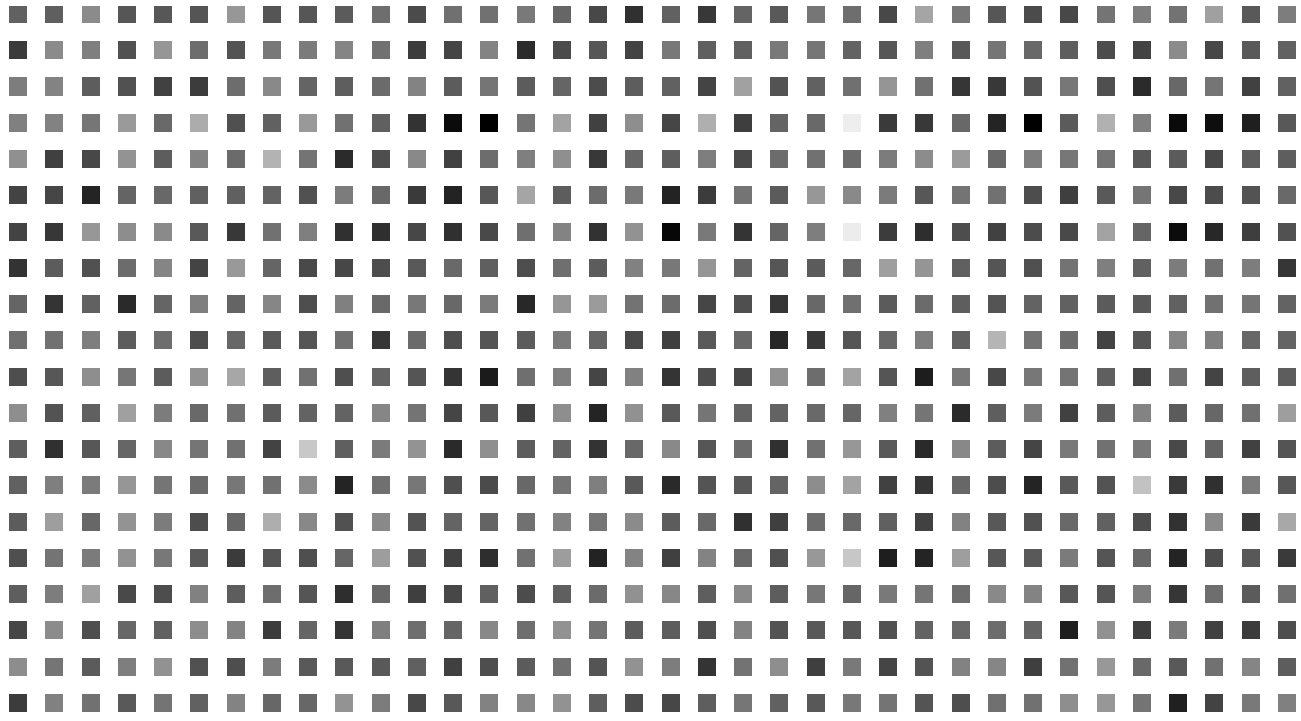

***** module.rae_layers.0.conv2d_layer_w.bias ##> torch.Size([20])
module.rae_layers.0.conv2d_layer_w2.weight  torch.Size([36, 20, 1, 1, 1])


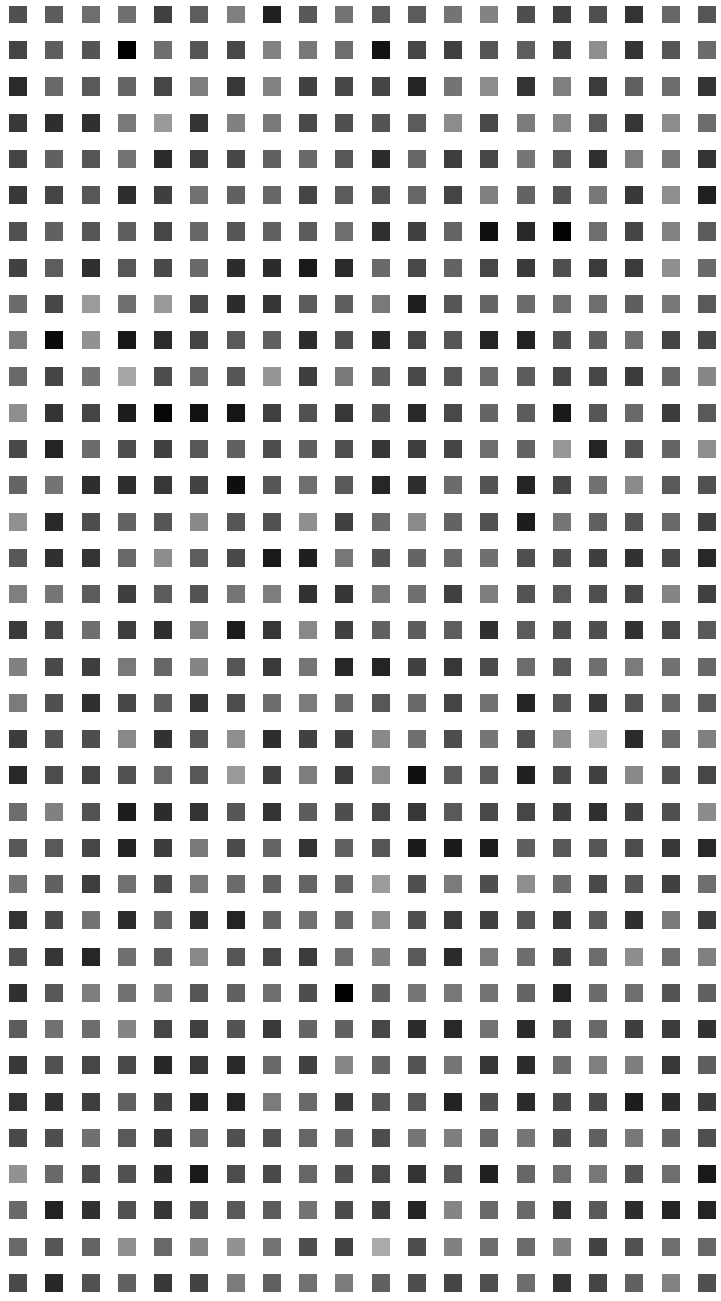

***** module.rae_layers.0.conv2d_layer_w2.bias ##> torch.Size([36])
module.rae_layers.0.deconv2d_layer_u2T.weight  torch.Size([36, 1, 11, 11, 1])


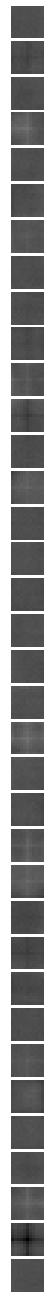

***** module.rae_layers.0.deconv2d_layer_u2T.bias ##> torch.Size([1])


In [10]:
for name, param in model.named_parameters():
    
    if len(param.shape)==3 and param.shape[1]>1 and param.shape[2]>1:
        for ii in range(param.shape[2]):
            print(name,"##>",param.shape,"  Channel ##>",ii)
            paramt=param[:,:,ii].data.cpu().numpy()
            print(paramt.shape)
#             plt.figure(figsize=paramt.shape/4.) 
            plt.imshow(paramt,cmap='gray') 
            plt.axis('off')
            plt.show()
    elif len(param.shape)==2 and param.shape[0]>1 and param.shape[1]>1:
        param=param.data.cpu().numpy()
        plt.figure(figsize=param.shape) 
        plt.imshow(param,cmap='gray') 
        plt.axis('off')
        plt.show()
    elif len(param.shape)==4:#[samples, seq, shape, shape, colorchannel]
        showSeq(0,name,param.data.unsqueeze(4),oneD=False,dpi=0.1)
    else:
        print("*****",name,"##>",param.shape)


In [0]:
import cProfile

def loop1(list1):
    for x in list1:
        list1[x] = x*x

# comment out when using with python -m cProfile test.py
cp = cProfile.Profile()
cp.enable()

for i in range(10000):
    list1 = [x for x in range(1000)]
    loop1(list1)    

cp.disable()
cp.print_stats()
69/


         20019 function calls in 1.161 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.085    0.085    1.161    1.161 <ipython-input-12-68ba29a41055>:11(<module>)
    10000    0.342    0.000    0.342    0.000 <ipython-input-12-68ba29a41055>:12(<listcomp>)
        1    0.000    0.000    0.000    0.000 <ipython-input-12-68ba29a41055>:15(<module>)
    10000    0.733    0.000    0.733    0.000 <ipython-input-12-68ba29a41055>:3(loop1)
        2    0.000    0.000    0.000    0.000 codeop.py:132(__call__)
        2    0.000    0.000    0.000    0.000 hooks.py:142(__call__)
        2    0.000    0.000    0.000    0.000 hooks.py:207(pre_run_code_hook)
        2    0.000    0.000    0.000    0.000 interactiveshell.py:1055(user_global_ns)
        2    0.000    0.000    1.161    0.580 interactiveshell.py:2832(run_code)
        2    0.000    0.000    0.000    0.000 ipstruct.py:125(__getattr__)
        2    0.000    0.000 

In [0]:
gr=make_dot(rec_frames_batch,params=dict(models[0].named_parameters()))
gr.graph_attr.update(size="150,150")

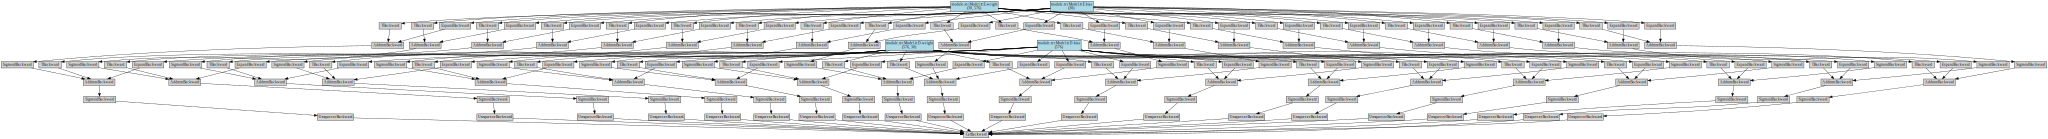

In [0]:
gr

In [0]:
gr.render('ae.gv', view=True)  

'ae.gv.pdf'

In [0]:
gr=make_dot(pre_frames_batch,params=dict(models[0].named_parameters()))
gr.graph_attr.update(size="150,150")

In [0]:
gr

In [0]:
gr.render('rae.gv', view=True)  